In [6]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Imports

In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [8]:
from scipy.signal import find_peaks

In [9]:
dataset = pd.read_csv('training-a.csv')

In [10]:
labels = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
raw_data = dataset.drop(['label'],axis=1)

In [11]:
labels.shape

(409,)

## Traitement

Les features qui nous intéressent sont (en mean et std): 
**time domain** RR intervals, S1, S2, systolic, diastolic, systolic/RR, diastolic/RR, systolic/diastolic, amplitude systole/S1, amplitude diastole/S2, skewness et kurtosis des amplitudes dans chaque phase
**frequency domain** median and mean power across 9 frequency bands (ranging from 25 to 400Hz), *MFCC features*,

In [12]:
phases_list = ['S1','S2','systole','diastole']
features_list = ['t1','t2','t12','t21']

In [33]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)])-np.mean(signal) #on ignore les NaN et on recentre le signal
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        #E = E/np.std(E)
        E = -1*(E**2) * np.log(E**2)

        #on met les petites valeurs à 0 
        # il faut d'abord calculer les maximums locaux 
        window_length = 750
        local_max = np.array([np.max(E[i-window_length:i+window_length]) for i in range(window_length,len(E)-window_length)])
        local_max = np.concatenate((local_max[0]*np.ones(window_length),local_max,local_max[-1]*np.ones(window_length)))
        s = np.std(E)
        m = np.mean(E)
        mask = E>local_max/5
        mask2 = np.abs(E-m)>s/2
        mask3 = E>np.mean(E)*2
        return E*mask
    
    def setStart(self,E):
        #on s'assure de bien commencer sur une phase S1 ou S2
        start = 0
        while E[start]==0:
            start += 1
        E = E [start:]
        return E, start
    
    def consec_count(self):
        e = self.setStart(self.envelogram())[0]
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segmentation(self):
        E = self.setStart(self.envelogram())[0] # l'envelogramme commencé sur un battement
        count_vec = self.consec_count() # le vecteur de comptage associé
        length_threshold=50
        beat_mask = count_vec<=length_threshold
        systole_mask = count_vec>length_threshold
        segmentation = np.asarray([])
        mean_beat_length = 0
        beat_counter = 0
        i = 0
        while i<count_vec.shape[0]:
            stop = i 
            #on calcule la longueur du pic
            while stop<count_vec.shape[0] and beat_mask[stop]:
                stop+=1
                
            #on calcule l'écart avec le pic suivant, pour voir s'il s'agit du même pic 
            next_stop = stop
            while next_stop<count_vec.shape[0] and not beat_mask[stop]:
                next_stop +=1
            if next_stop-stop<0.150*self.fs: #si l'écart entre les deux pics est de moins de 50ms, c'est un split
                stop = next_stop
                
            #un battement long est un battement S1
            if stop-i>mean_beat_length:
                segmentation = np.concatenate((segmentation,np.repeat('S1',stop-i)))
                current_seq = {'beat':'S1','passive':'systole'}
                
            #un battement court est un battement S2
            else:
                segmentation = np.concatenate((segmentation,np.repeat('S2',stop-i)))
                current_seq = {'beat':'S2','passive':'diastole'}
                
            #update beat length and parser
            mean_beat_length = np.average([stop-i,mean_beat_length],weights=[1,beat_counter])
            beat_counter += 1
            i = stop
                
            while stop<count_vec.shape[0] and systole_mask[stop]:
                stop+=1
                
            segmentation = np.concatenate((segmentation,np.repeat(current_seq['passive'],stop-i)))
            #update parser
            i = stop
            
        return segmentation,E
    
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)
        return res[res!=0]
    
    
    def extractFeatures(self):
        segmentation, E = self.segmentation()
        features = np.array([])
        #time features
        for phase in phases_list:
            time_features = self.timeLengths(segmentation,phase)
            features = np.append(features,[np.mean(time_features),np.min(time_features),
                                 np.max(time_features),np.std(time_features)])
            
        #peak features    
        p_S1 = []
        p_S2 = []
        borne = []
        for i in range(len(segmentation)-1):
            if segmentation[i-1] != segmentation[i]:
                borne.append(i)
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == 'S1':
                peaks, _ = find_peaks(E[borne[i]:borne[i+1]],height=0,distance = borne[i+1])
                if len(peaks) != 0:
                    index = borne[i] + peaks[0]
                    p_S1.append(E[index])    
            if segmentation[borne[i]] == 'S2':
                peaks, _ = find_peaks(E[borne[i]:borne[i+1]],height=0,distance = borne[i+1])
                if len(peaks) != 0:
                    index = borne[i] + peaks[0]
                    p_S2.append(E[index])
        features = np.append(features,[np.mean(p_S1),np.min(p_S1),np.max(p_S1),np.std(p_S1)])
        features = np.append(features,[np.mean(p_S2),np.min(p_S2),np.max(p_S2),np.std(p_S2)])
        
        #mean12 feature
        features = np.append(features,max(features[8],features[12]))
        
        return features

## Visualisation

In [21]:
time_length = 10000
sample = raw_data.loc[1][:time_length]

In [22]:
pcg = PCG(sample)
segmentation,E = pcg.segmentation()

Text(0,0.5,'amplitude normalisée')

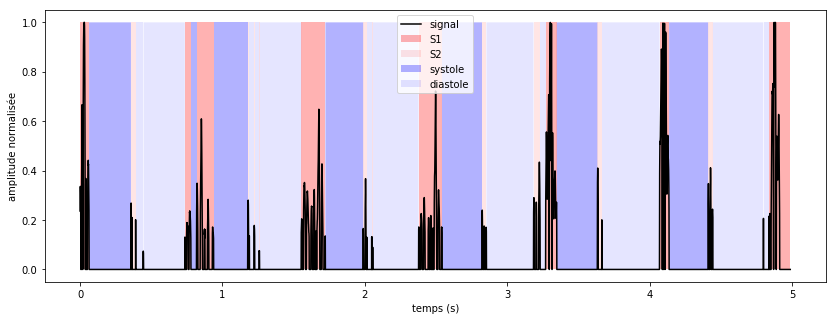

In [23]:
plt.figure(figsize=(14,5))
E,lag = pcg.setStart(pcg.envelogram())
l = time_length-lag
x = np.linspace(0,l/2000,l)
plt.fill_between(x,0,1,where = segmentation=='S1',facecolor='r',alpha=.3,label='S1')
plt.fill_between(x,0,1,where = segmentation=='S2',facecolor='r',alpha=.1,label='S2')
plt.fill_between(x,0,1,where = segmentation=='systole',facecolor='b',alpha=.3,label='systole')
plt.fill_between(x,0,1,where = segmentation=='diastole',facecolor='b',alpha=.1,label='diastole')

plt.plot(x,E/np.max(E),'k',label='signal')
plt.legend()
plt.xlabel('temps (s)')
plt.ylabel('amplitude normalisée')

## Analyse des features

In [17]:
n_samples = raw_data.shape[0]

In [68]:
t1,t2,t12,t21=[],[],[],[]
for i in range(n_samples):
    try:
        pcg = PCG(raw_data.loc[i])
        ft = pcg.extractFeatures()
        t1.append(ft['t1'][0])
        t2.append(ft['t2'][0])
        t12.append(ft['t12'][0])
        t21.append(ft['t21'][0])
    except: 
        print(i)
        pass

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


255
262


In [84]:
good = labels[:n_samples]==1
bad = labels[:n_samples]==-1

In [85]:
t1 = np.asarray(t1)
t2 = np.asarray(t2)
t12 = np.asarray(t12)
t21 = np.asarray(t21)
mean12 = np.asarray([max(t12[i],t21[i]) for i in range (len(t12))])
tlag = np.asarray([np.min(t1[i]+t2[i]+t12[i]+t21[i]) for i in range(len(t12))])

## Classification

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [47]:
features = np.zeros(25)
final_labels = []
for i in range (n_samples):
    try:
        pcg = PCG(raw_data.loc[i]) 
        ft = pcg.extractFeatures()
        features = np.row_stack((features,ft))
        final_labels.append(labels[i])
    except: 
        print(i)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


64
255
262


In [36]:
pca = PCA(n_components = 10)
X_red = pca.fit_transform(features)

In [70]:
rf = RandomForestClassifier(n_estimators=10,max_depth=2)
svm = SVC(C=100,gamma=100)
nn = MLPClassifier()
logit = LogisticRegression()
for clf in [logit,rf,svm,nn]:
    print(cross_val_score(rf,features,final_labels,cv=2))

[0.69117647 0.70792079]
[0.69607843 0.6980198 ]
[0.71078431 0.72277228]
[0.70098039 0.71287129]


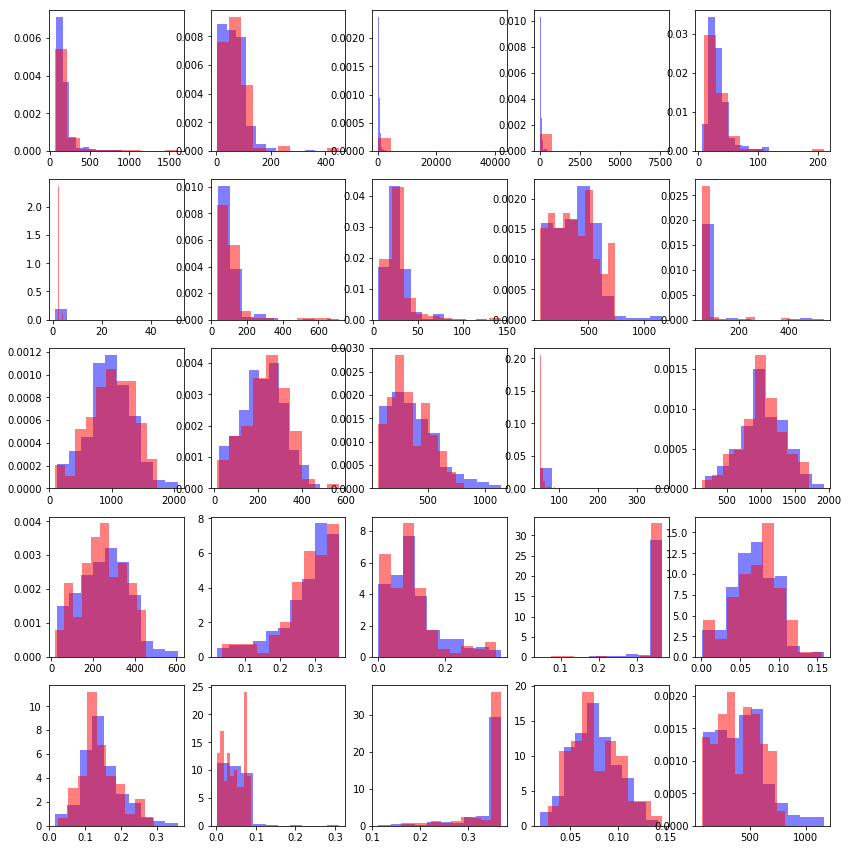

In [108]:
fig = plt.figure(figsize=(14,15))
prov_labels = final_labels[3:]
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ft = features[:,i]
    normalft = ft[prov_labels==1]
    anormalft = ft[prov_labels==-1]
    ax.hist(normalft,density=True,color='b',alpha=0.5)
    ax.hist(anormalft,density=True,color='r',alpha=0.5)